In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
parquet_file = 'data.parquet'
df = pd.read_parquet(parquet_file)

In [3]:
csv_file = 'data.csv'
df.to_csv(csv_file, index=False)

In [4]:
dataset = pd.read_csv(csv_file)
data = dataset.sample(n=1500, random_state = 1)
print(data.head())

                                                                                                                                                                                                      chapter  \
7700  II. The Mail\n\n\nIt was the Dover road that lay, on a Friday night late in November,\nbefore the first of the persons with whom this history has business.\nThe Dover road lay, as to him, beyond t...   
3680  Actus Tertius. Scena Prima.\n\nEnter Bullingbrooke, Yorke, Northumberland, Rosse, Percie,\nWilloughby,\nwith Bushie and Greene Prisoners.\n\n  Bull. Bring forth these men:\nBushie and Greene, I wi...   
1221  THE STRENGTH OF GOD\n\nThe Reverend Curtis Hartman was pastor of the\nPresbyterian Church of Winesburg, and had been in that\nposition ten years. He was forty years old, and by his\nnature very si...   
6963  Much rain fell in the night; and the next morning there blew a bitter\nwintry wind out of the north-west, driving scattered clouds. For all\nthat, and before 

In [5]:
data.rename(columns={'chapter': 'text'}, inplace=True)
data

,text,summary
7700,"II. The Mail\n\n\nIt was the Dover road that lay, on a Friday night late in November,\nbefore the first of the persons with whom this history has business.\nThe Dover road lay, as to him, beyond t...","In England, the Dover mail coach makes its way up a hill one late November night. The foreboding atmosphere of night and mist makes everyone uneasy -- the passengers, the coachman, and the guard. ..."
3680,"Actus Tertius. Scena Prima.\n\nEnter Bullingbrooke, Yorke, Northumberland, Rosse, Percie,\nWilloughby,\nwith Bushie and Greene Prisoners.\n\n Bull. Bring forth these men:\nBushie and Greene, I wi...","At Bristol Castle in southwestern England, a short distance south of Berkeley Castle, Henry Bolingbroke and his men have apprehended Bushy and Greene, who remain loyal to King Richard. Bolingbroke..."
1221,"THE STRENGTH OF GOD\n\nThe Reverend Curtis Hartman was pastor of the\nPresbyterian Church of Winesburg, and had been in that\nposition ten years. He was forty years old, and by his\nnature very si...","Though the Reverend Curtis Hartman is a pastor of the Presbyterian Church of Winesburg, it is a hardship for him to preach his sermons. He prays to the Lord to give him the strength to preach well..."
6963,"Much rain fell in the night; and the next morning there blew a bitter\nwintry wind out of the north-west, driving scattered clouds. For all\nthat, and before the sun began to peep or the last of t...","I Go to the Queen's Ferry David sleeps a restless night, aware of his uncle's great dislike, even hatred of him. But, in his youth, David thinks himself the better man, and makes plans to trick hi..."
6442,The Black Eagle (_Zum Schwartzen Adler_) in the Adlergasse was a\nprosperous tavern of the second rate. The house was two hundred years\nold and had been in the Bauer family all that time.\n\nHad ...,"It's been four weeks since Ani and crew left Kildenree, and by now everyone is a little homesick. Talone tells her that they've reached the halfway point, which he can tell by a mark he sees on a ..."
...,...,...
2939,"ACT IV. SCENE I.\nCyprus. Before the castle.\n\nEnter Othello and Iago.\n\n IAGO. Will you think so?\n OTHELLO. Think so, Iago?\n IAGO. What,\...","At the beginning of the scene, Othello is hovering uneasily between Iagos wicked version of events and his knowledge of Desdemonas pure nature. When Iago tells him that Cassio has confessed to him..."
4017,"CHAPTER IV.\n\n MILENDO, THE METROPOLIS OF LILLIPUT, DESCRIBED TOGETHER WITH THE\n EMPEROR'S PALACE. A CONVERSATION BETWEEN THE AUTHOR AND A PRINCIPAL\n SECRETARY, CONCERNING THE AFFAI...","After Gulliver gets his freedom, the first thing he does is to ask the Emperor if he can go into Mildendo, the main city of Lilliput. The Emperor agrees, and Gulliver steps into the town. He walks..."
1457,"Sophie came at seven to dress me: she was very long indeed in\naccomplishing her task; so long that Mr. Rochester, grown, I suppose,\nimpatient of my delay, sent up to ask why I did not come. She...","Jane looks at herself in the mirror, dressed, and ready for her marriage to Rochester. When Rochester sees her he says, Fair as a lily, and not only the pride of his life, but the desire of his ey..."
3502,"Actus Quintus. Scena Prima.\n\n\nEnter with Drumme and Colours, Edmund, Regan. Gentlemen, and\nSouldiers.\n\n Bast. Know of the Duke if his last purpose hold,\nOr whether since he is aduis'd by o...","Edmund sends an officer to learn of Albany's plans since he has become so fickle. Regan approaches Edmund, sweetly asking him if he loves her sister and if he has ever found his way into her bed. ..."


In [6]:
data.drop_duplicates(subset=['text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)

    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]

    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [11]:
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))

In [12]:
cleaned_text[:2]

['ii mail dover road lay friday night late november first persons history business dover road lay beyond dover mail lumbered shooter hill walked hill mire side mail rest passengers least relish walking exercise circumstances hill harness mud mail heavy horses three times already come stop besides drawing coach across road mutinous intent taking back blackheath reins whip coachman guard however combination read article war forbade purpose otherwise strongly favour argument brute animals endued reason team capitulated returned duty drooping heads tremulous tails mashed way thick mud floundering stumbling whiles falling pieces larger joints often driver rested brought stand wary wo ho ho near leader violently shook head everything upon like unusually emphatic horse denying coach could got hill whenever leader made rattle passenger started nervous passenger might disturbed mind steaming mist hollows roamed forlornness hill like evil spirit seeking rest finding none clammy intensely cold mi

In [13]:
cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [14]:
cleaned_summary[:2]

['in england the dover mail coach makes its way up hill one late november night the foreboding atmosphere of night and mist makes everyone uneasy the passengers the coachman and the guard highway robberies are common and the travelers are as wary of each other as they are of anyone else they might meet on the road as the coach reaches the top of the hill the travelers hear horse approaching at gallop the rider jerry is messenger from tellson bank in london and he has message for one of the passengers mr jarvis lorry an employee of the bank mr lorry reads the message which states wait at dover for mam selle mr lorry tells jerry to return the answer recalled to life and the coach continues on its way as jerry gallops back to london he muses over mr lorry mysterious response',
 'at bristol castle in southwestern england short distance south of berkeley castle henry bolingbroke and his men have apprehended bushy and greene who remain loyal to king richard bolingbroke accuses them of having

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

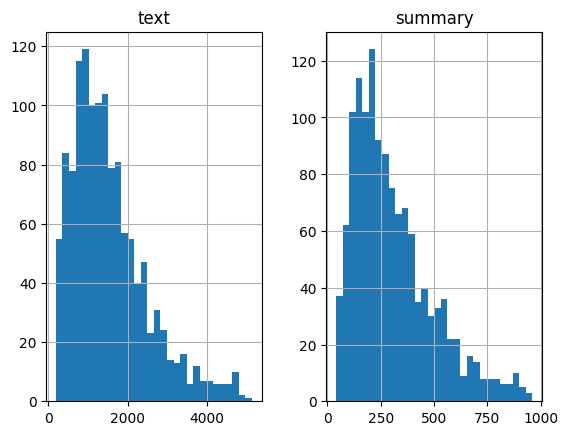

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [18]:
count=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 500):
        count=count+1
print(count/len(data['cleaned_summary']))

0.8414164742109315


In [19]:
count=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 3500):
        count=count+1
print(count/len(data['cleaned_text']))

0.9515011547344111


In [20]:
max_text_len=3500
max_summary_len=500

In [21]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

new_text=[]
new_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        new_text.append(cleaned_text[i])
        new_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':new_text,'summary':new_summary})

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,ii mail dover road lay friday night late november first persons history business dover road lay beyond dover mail lumbered shooter hill walked hill mire side mail rest passengers least relish walk...,sostok in england the dover mail coach makes its way up hill one late november night the foreboding atmosphere of night and mist makes everyone uneasy the passengers the coachman and the guard hig...
1,actus tertius scena prima enter bullingbrooke yorke northumberland rosse percie willoughby bushie greene prisoners bull bring forth men bushie greene vex soules much vrging pernitious liues twere ...,sostok at bristol castle in southwestern england short distance south of berkeley castle henry bolingbroke and his men have apprehended bushy and greene who remain loyal to king richard bolingbrok...
2,strength god reverend curtis hartman pastor presbyterian church winesburg position ten years forty years old nature silent reticent preach standing pulpit people always hardship wednesday morning ...,sostok though the reverend curtis hartman is pastor of the presbyterian church of winesburg it is hardship for him to preach his sermons he prays to the lord to give him the strength to preach wel...
3,much rain fell night next morning blew bitter wintry wind north west driving scattered clouds sun began peep last stars vanished made way side burn plunge deep whirling pool aglow bath sat beside ...,sostok go to the queen ferry david sleeps restless night aware of his uncle great dislike even hatred of him but in his youth david thinks himself the better man and makes plans to trick his uncle...
4,pass night mr kenge told us arrived room mrs jellyby turned said took granted knew mrs jellyby really sir returned perhaps mr carstone miss clare knew nothing whatever mrs jellyby deed mrs jellyby...,sostok telescopic philanthropy mr kenge tells the young people they will stay the night with mrs jellyby very great philanthropist who devotes herself to the african subject when richard asks what...


In [23]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [24]:
thresh=30

count=0
total_count=0
freq=0
total_freq=0

for key,value in x_tokenizer.word_counts.items():
    total_count=total_count+1
    total_freq=total_freq+value
    if(value<thresh):
        count=count+1
        freq=freq+value

print("% of rare words in vocabulary:", (count/total_count)*100)
print("Total Coverage of rare words:", (freq/total_freq)*100)

% of rare words in vocabulary: 87.17065349280638
Total Coverage of rare words: 15.582041939327656


In [25]:
print(count)
print(total_count)

40231
46152


In [26]:
print(freq)
print(total_freq)

198899
1276463


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

x_tokenizer = Tokenizer(num_words = total_count-count)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [28]:
x_voc

5922

In [29]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [30]:
thresh=20

count=0
total_count=0
freq=0
total_freq=0

for key,value in y_tokenizer.word_counts.items():
    total_count=total_count+1
    total_freq=total_freq+value
    if(value<thresh):
        count=count+1
        freq=freq+value

print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(freq/total_freq)*100)

% of rare words in vocabulary: 90.75907590759076
Total Coverage of rare words: 19.937380368788922


In [31]:
print(count)
print(total_count)

13475
14847


In [32]:
print(freq)
print(total_freq)

46039
230918


In [33]:
y_tokenizer = Tokenizer(num_words=total_count-count)
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [34]:
y_voc

1373

In [35]:
ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [36]:
ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [37]:
from keras_self_attention import SeqSelfAttention

latent_dim = 30
embedding_dim=1000

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = SeqSelfAttention(attention_activation='softmax', name='attention_layer')
attn_out = attn_layer(decoder_outputs)

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 3500,      │  5,922,000 │ input_layer[0][0] │
│ (Embedding)         │ 1000)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None,      │  1,373,000 │ input_layer_1[0]… │
│ (Embedding)         │ 1000)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 3500,     │    123,720 │ embedding[0][0]   │
│                     │ 30), (None, 30),  │            │                   │
│                     │ (None, 30)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    123,720 │ embedding_1[0][0… │
│                     │ 30), (None, 30),  │            │ lstm[0][1],       │
│                     │ (None, 30)]       │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 30)  │      1,985 │ lstm_1[0][0]      │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 60)  │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │     83,753 │ concat_layer[0][… │
│ (TimeDistributed)   │ 1373)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,628,178 (29.10 MB)

 Trainable params: 7,628,178 (29.10 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy')

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [40]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=16,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                )

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - loss: 7.1334 - val_loss: 6.8176
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 433s 7s/step - loss: 6.5867 - val_loss: 5.6098
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 423s 7s/step - loss: 4.9083 - val_loss: 3.5109
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 436s 7s/step - loss: 3.2647 - val_loss: 3.3379
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 422s 7s/step - loss: 3.0440 - val_loss: 3.1887
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 433s 7s/step - loss: 2.9580 - val_loss: 3.1093
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - loss: 2.8655 - val_loss: 3.0712
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - loss: 2.8895 - val_loss: 3.0492
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - loss: 2.8403 - val_loss: 3.0340
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2823s 48s/step - loss: 2.8385 - val_loss: 3.0219
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 371s 6s/step - loss: 2.7753 - val_loss: 3.0116
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - loss: 2

In [51]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [52]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf = attn_layer(decoder_outputs2)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_token = reverse_target_word_index.get(sampled_token_index, 'UNK')

        if(sampled_token!='eostok'):
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence.strip()

In [54]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString = newString + reverse_target_word_index.get(i, 'UNK') + ' '
    return newString.strip()

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index.get(i, 'UNK') + ' '
    return newString.strip()

In [55]:
for i in range(0, 2):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: scene iii another part island enter antonio others go sir old bones ache indeed forth rights patience needs must rest old lord cannot blame thee weariness spirits sit rest even put hope keep longer drown thus stray find sea search land well let go ant aside right glad hope one purpose resolved effect aside ant next advantage take ant aside let night travel cannot use fresh aside ant say night solemn strange music harmony good friends hark sweet music enter invisible enter several strange shapes bringing dance gentle actions king eat depart give us kind heavens living believe one tree throne one hour ant believe else want credit come sworn tis true travellers ne er lie though fools home condemn em report would believe say saw islanders people island though monstrous shape yet note manners gentle kind human generation shall find many nay almost pros aside honest lord thou hast said well present worse devils cannot much shapes gesture sound expressing although want use tongue kind

In [56]:
print("Sample target word index:", {k: target_word_index[k] for k in list(target_word_index)[:10]})
print("Sample reverse target word index:", {k: reverse_target_word_index[k] for k in list(reverse_target_word_index)[:10]})
print("Sample source word index:", {k: x_tokenizer.word_index[k] for k in list(x_tokenizer.word_index)[:10]})
print("Sample reverse source word index:", {k: reverse_source_word_index[k] for k in list(reverse_source_word_index)[:10]})

Sample target word index: {'the': 1, 'to': 2, 'and': 3, 'he': 4, 'is': 5, 'that': 6, 'of': 7, 'she': 8, 'in': 9, 'her': 10}
Sample reverse target word index: {1: 'the', 2: 'to', 3: 'and', 4: 'he', 5: 'is', 6: 'that', 7: 'of', 8: 'she', 9: 'in', 10: 'her'}
Sample source word index: {'said': 1, 'would': 2, 'one': 3, 'could': 4, 'mr': 5, 'like': 6, 'man': 7, 'little': 8, 'good': 9, 'know': 10}
Sample reverse source word index: {1: 'said', 2: 'would', 3: 'one', 4: 'could', 5: 'mr', 6: 'like', 7: 'man', 8: 'little', 9: 'good', 10: 'know'}


In [57]:
import json
model_json = model.to_json()

with open('summary_model.json', 'w') as json_file:
    json_file.write(model_json)
    
print("Model saved as summary_model.json")

Model saved as summary_model.json


In [58]:
model.save('summary_model.h5')

print("Model saved as summary_model.h5")

Model saved as summary_model.h5
